In [1]:
# Basic environment modules
import numpy as np
import pandas as pd
import psycopg2 as pg # PostgreSQL module
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import font_manager
import matplotlib.font_manager as fm

# Data analysis modules
from CoolProp.CoolProp import PropsSI
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.integrate import ode
from scipy.interpolate import griddata
from sqlalchemy import create_engine

# User-defined libraries
from Model import *
from PhysicalProperty import *
from StructuredQuery import *
from Numeric import *
from Authentication import *

# Set the display format to show 6 decimal places
pd.options.display.float_format = '{:.6f}'.format

print("Import modules successfully.")

# load class instances
sql = StructuredQuery()
pro = PhysicalProperty()
mod = Model()
oau = Authentication()

Import modules successfully.
Construct connection string and update
SQL library is successfully started.
Property_OSV is successfully started.
Models of boiling heat transfer is successfully started.
Authentication is successfully started.


In [2]:
# load data

# Load json file (Security)
json_parse = oau.get_apikey(json_filename='key.json')
json_res = pd.json_normalize(json_parse['sql'])

# Set query from DB
sql = "SELECT * FROM CHF.deng_aaa_res_chf_tb"

# Connect DB server
#(conn, db_engine) = sql.connect(json_res["host"][1], json_res["dbname"][1], json_res["user"][1], json_res["port"][1], json_res["password"][1], json_res["service"][1]) #postgreSQL
connect = pys.connect(host=json_res["host"][1], user = json_res["user"][1], password = json_res["password"][1], cursorclass=pys.cursors.DictCursor)
cur = connect.cursor()
cur.execute(sql)

result = cur.fetchall()
prop_tb = pd.DataFrame(result)

del result, sql

# Set query from DB
sql = "SELECT * FROM CHF.physicalproperties"
cur.execute(sql)
result = cur.fetchall()
pp_tb = pd.DataFrame(result)

cur.close()
del result, sql, connect # delete quiry log

print("Loading database completed. data size: {}".format(len(prop_tb)))
print("Loading database completed. data size: {}".format(len(pp_tb)))

Loading database completed. data size: 19658
Loading database completed. data size: 170


In [4]:
prop_tb.columns

Index(['index', 'idx', 'tno', 'runno', 'geo', 'flow', 'refri', 'hs', 'p',
       'doi', 'dio', 'dh', 'gap', 'lh', 'v', 'g', 'q', 'q2', 'tin', 'tout',
       'degtin', 'degtout', 'xi', 'xe', 'enthin', 'enthout', 'de', 'tsat',
       'pcrit', 'rdcp', 'rhof', 'rhov', 'muf', 'muv', 'kf', 'kv', 'hfo', 'hvo',
       'lam', 'wtsat', 'wpcrit', 'wrdcp', 'wrhof', 'wrhov', 'wmuf', 'wmuv',
       'whfo', 'whvo', 'wlam', 'cpf', 'cpv', 'sigma', 'wcpf', 'wcpv', 'wsigma',
       'wkf', 'wkv', 'hin', 'hout', 'hval', 'param_hval', 'yn_hval', 'pe',
       're', 'we', 'bd', 'pr', 'prv', 'ca', 'lc', 'org_dtsz', 'org_xosv',
       'gr_p', 'gr_g', 'gr_q', 'gr_dh', 'gr_lh', 'gr_xi', 'mth_xosv', 'log_id',
       'cal_xt', 'cal_xe', 'cal_xosv', 'converged', 'alpha', 'gamma', 'zxt',
       'qcal', 'j_alpha', 'j_gamma', 'j_zxt', 'j_old_qcal', 'qval', 'j_qcal'],
      dtype='object')

In [ ]:
# Set new parameter

prop_tb['param'] =
prop_tb['kpa'] =
prop_tb['vf_alpha'] = prop_tb.apply(lambda x: 1/(1+x['param']+x['kpa']*x['org_xosv']), axis = 1) # Y value


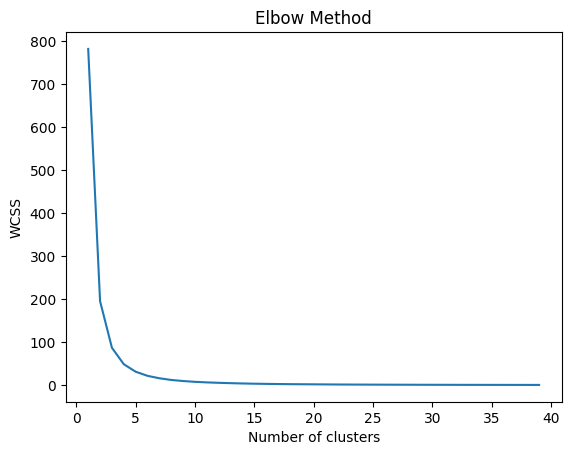

4


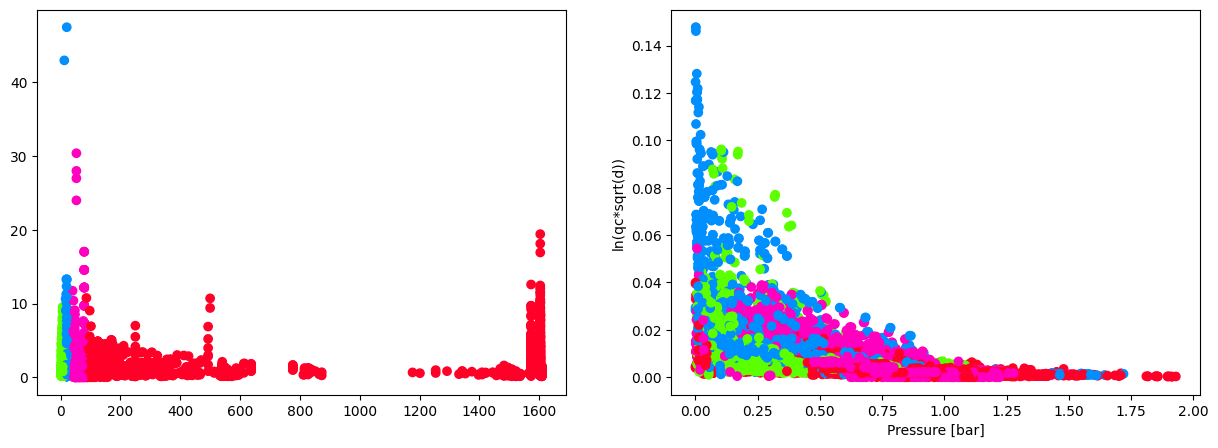

In [3]:
# Kmeans Algorithm
# Preparing converged dataset
val_tb = prop_tb[(prop_tb['converged']==100) & (prop_tb['yn_hval'] == 100) & (prop_tb['refri'] == 'H2O') & (prop_tb['dh'] != np.nan)].copy()

val_tb['Y_qcal'] = val_tb.apply(lambda x: ((x['q']*10**3*x['dh']/x['lam'])), axis = 1) # Y value
val_tb['X_zxt'] = val_tb.apply(lambda x: (x['cal_xt']), axis = 1) # X value

# Preparing linear form of CHF correlation
X = val_tb[['rdcp']]

from sklearn.preprocessing import QuantileTransformer
# Scaling
scaler = QuantileTransformer()
X_scaled = scaler.fit_transform(X)

# Calculate density of each sample
no_k = 40
wcss = []

for k in range(1, no_k):
    kmeans = KMeans(n_clusters=k, random_state=0, max_iter=1000, n_init=50)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values as a function of the number of clusters
plt.plot(range(1, no_k), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

from kneed import KneeLocator
# Find the elbow point in the WCSS curve
kneedle = KneeLocator(range(1, no_k), wcss, curve = 'convex', direction='decreasing')
elbow_point = kneedle.elbow
print(elbow_point)

# Run K-means clustering for elbow point
kmeans = KMeans(n_clusters=elbow_point, random_state=0, max_iter=1000, n_init=1).fit(X, sample_weight=1)

# Extract the labels (cluster assignments) and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Add the labels and centroids to the original DataFrame
val_tb['cluster'] = labels
val_tb['centroid_distance'] = kmeans.transform(X).min(axis=1)

# Create a 1X2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(15,5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Set configuration of figure
axs[0].scatter(val_tb['rhof']/val_tb['rhov'], val_tb['q'], c=val_tb['cluster'], cmap ='gist_rainbow')
axs[1].scatter(val_tb['X_zxt'], val_tb['Y_qcal'], c=val_tb['cluster'], cmap ='gist_rainbow')
plt.xlabel('Pressure [bar]')
plt.ylabel('ln(qc*sqrt(d))')
plt.show()

In [ ]:
# DBSCAN algorithm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Preparing linear form of CHF correlation
X = val_tb[['rdcp']]

scaler = QuantileTransformer()
X_scaled = scaler.fit_transform(X)

# Run DBSCAN algorithm
dbscan = DBSCAN(eps=0.00001, min_samples = 5)
labels = dbscan.fit_predict(X)

# Plot the results
plt.scatter(X['rdcp'], val_tb['q'], c=labels, cmap ='gist_rainbow')
plt.show()

In [ ]:
# Clustering grouping and calculation for loop

# normalize the dataframe using MinMax Scaler
def cal_mnmx(df, cols):
    # create a MinMaxScaler object
    scaler = MinMaxScaler()

    # fit the scaler to the dataframe
    scaler.fit(df[cols])
    # transform the selected columns of the dataframe using the scaler
    res = pd.DataFrame(scaler.transform(df[cols]), columns=cols)

    return res

from sklearn.metrics import r2_score as r2
# define a function to perform linear regression on a group
def cal_lr(df):
    # create a linear regression object
    model = LinearRegression()
    cluster_value = len(df['cluster'])
    X = df[['X_zxt']].values.reshape(-1,1)
    y = df['Y_qcal'].values.reshape(-1,1)

    # fit the model to the data
    res_model = model.fit(X, y)
    r2_score=r2(y, res_model.predict(X))

    # return the slop and intercept of the regression line
    return pd.Series({'no': cluster_value, 'g_alpha': res_model.intercept_[0], 'g_gamma': res_model.coef_[0][0], 'r2_score': r2_score})

# group the DataFrame by the 'cluster' column
#val_group = val_tb.groupby('cluster').apply(cal_lr)
val_group_tb = val_tb.groupby('cluster').apply(cal_lr).reset_index()
val_group_tb

In [ ]:
# concatenate the two dataframe along rows
result = pd.merge(val_tb, val_group_tb, left_on='cluster', right_on = val_group_tb['cluster'], how='outer').copy()
#result2 = pd.merge(result, tmp_res, on = result.index, how='outer').copy()

# 이 부분은 함수로 데이터프레임에 적용할 수 있도록 수정해야 함.
lr = LinearRegression()


# Set the X and Y data
X = result[['rdcp']]
Y = result['g_alpha']

# Perform polynomial regression
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
lr.fit(X_poly, Y)
r2_train = r2(Y, lr.predict(X_poly))

print('Coefficients: ', lr.coef_)
print('Intercept:', round(lr.intercept_,6))
print('R2: ', round(r2_train*100,2))

# Plot graph
fig = plt.figure()
ax1 = fig.add_subplot(4, 4, 1)
ax2 = fig.add_subplot(4, 4, 2)
ax3 = fig.add_subplot(4, 4, 3)
ax4 = fig.add_subplot(4, 4, 4)

plt.xlabel('Reduced Pressure [-]')
plt.ylabel('Alpha or Gamma')
plt.legend(loc='upper left')
ax1.scatter(result.loc[:, 'rdcp'], result.loc[:, 'g_alpha'], c=result['dh'], cmap ='gist_rainbow')
ax2.scatter(result.loc[:, 'rdcp'], result.loc[:,'g_gamma'], c=result['p'], cmap ='gist_rainbow')
ax3.scatter((result.loc[:, 'X_zxt']), (result.loc[:,'Y_qcal'])/result.loc[:,'g_alpha'], c=result['rdcp'], cmap ='gist_rainbow')
ax4.scatter(result.loc[:,'g_alpha'], result.loc[:,'g_gamma'], c=result['rdcp'], cmap ='gist_rainbow')

#ax1.plot(xs,ys1,'r-',lw=3)
#ax2.plot(xs,ys2,'b-',lw=3)